In [1]:
import pandahouse
import pandas as pd
import seaborn as sns
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt

# Задача
Протестируем один из новых алгоритмов рекомендации постов. \
Эксперимент проходил с 2023-06-30 по 2023-07-06 включительно. Для эксперимента были задействованы 2 и 1 группы. В группе 2 был использован новый алгоритм рекомендации постов, группа 1 использовалась в качестве контроля. \
Основная гипотеза заключается в том, что новый алгоритм во 2-й группе приведет к увеличению CTR.  \
Задача — проанализировать данные АB-теста.
1. Выбрать метод анализа и сравнить CTR в двух группах (t-тест, Пуассоновский бутстреп, тест Манна-Уитни, t-тест на сглаженном ctr (α=5) а также t-тест и тест Манна-Уитни поверх бакетного преобразования).
2. Сравнить данные этими тестами. А еще посмотреть на распределения глазами. Почему тесты сработали так как сработали? 
3. Описать потенциальную ситуацию, когда такое изменение могло произойти.
4. Напишисать рекомендацию, будем ли мы раскатывать новый алгоритм на всех новых пользователей или все-таки не стоит.

In [2]:
# Выгружаем пользователей, которые участвовали в A/B тесте из групп 2 и 1

connection = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'simulator_20230720',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

q = """
SELECT
  exp_group,
  user_id,
  sum(action = 'like') as likes,
  sum(action = 'view') as views,
  likes / views as ctr
FROM
  simulator_20230720.feed_actions
WHERE
  toDate(time) between '2023-06-30'
  and '2023-07-06'
  and exp_group in (2, 1)
GROUP BY
  exp_group,
  user_id
"""

df = pandahouse.read_clickhouse(q, connection=connection)

In [3]:
df

,exp_group,user_id,likes,views,ctr
0,1,109963,3,15,0.200000
1,1,26117,32,141,0.226950
2,1,138232,18,73,0.246575
3,1,18392,7,32,0.218750
4,1,26295,39,141,0.276596
...,...,...,...,...,...
19892,2,17146,0,10,0.000000
19893,1,30872,11,59,0.186441
19894,2,25383,42,127,0.330709
19895,2,139020,17,41,0.414634


In [4]:
df.groupby('exp_group').count()

,user_id,likes,views,ctr
exp_group,,,,
1,10020,10020,10020,10020
2,9877,9877,9877,9877


In [7]:
sns.set(rc={'figure.figsize': (18, 12) })

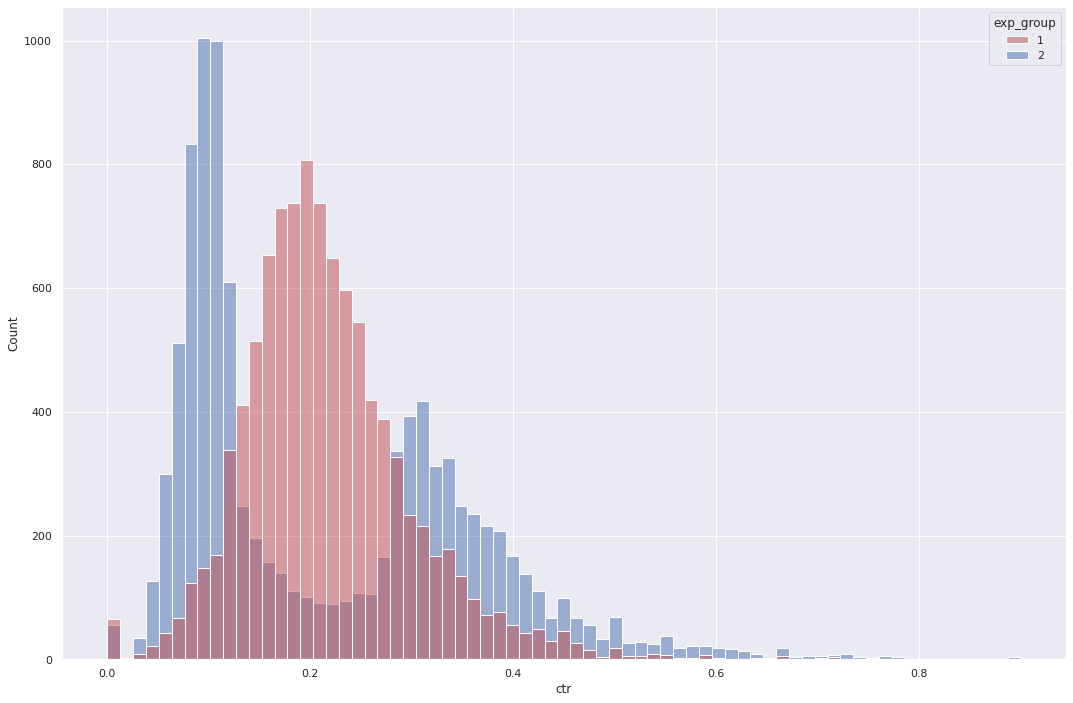

In [8]:
# визуализируем распределение CTR в группах

groups = sns.histplot(data = df, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

## T-test


In [9]:
stats.ttest_ind(df[df.exp_group == 1].ctr,
                df[df.exp_group == 2].ctr,
                equal_var=False)

Ttest_indResult(statistic=0.4051491913112757, pvalue=0.685373331140751)

Согласно t-тесту p value получается достаточно большим. То есть мы не можем принять гипотезу о том, что новая система рекомендаций приводит к увееличению CTR.

## Тест Манна — Уитни

In [10]:
stats.mannwhitneyu(df[df.exp_group == 1].ctr, 
                   df[df.exp_group == 2].ctr,
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=55189913.0, pvalue=4.632205841806026e-45)

Тест Манна — Уитни показывает противоположный результат p value получается сильно меньше 0.05. То есть гипотеза о том, что новая система рекомендаций приводит к увееличению CTR принимается.

## T-тест на сглаженном ctr (α=5)

<Axes: xlabel='ctr', ylabel='Count'>

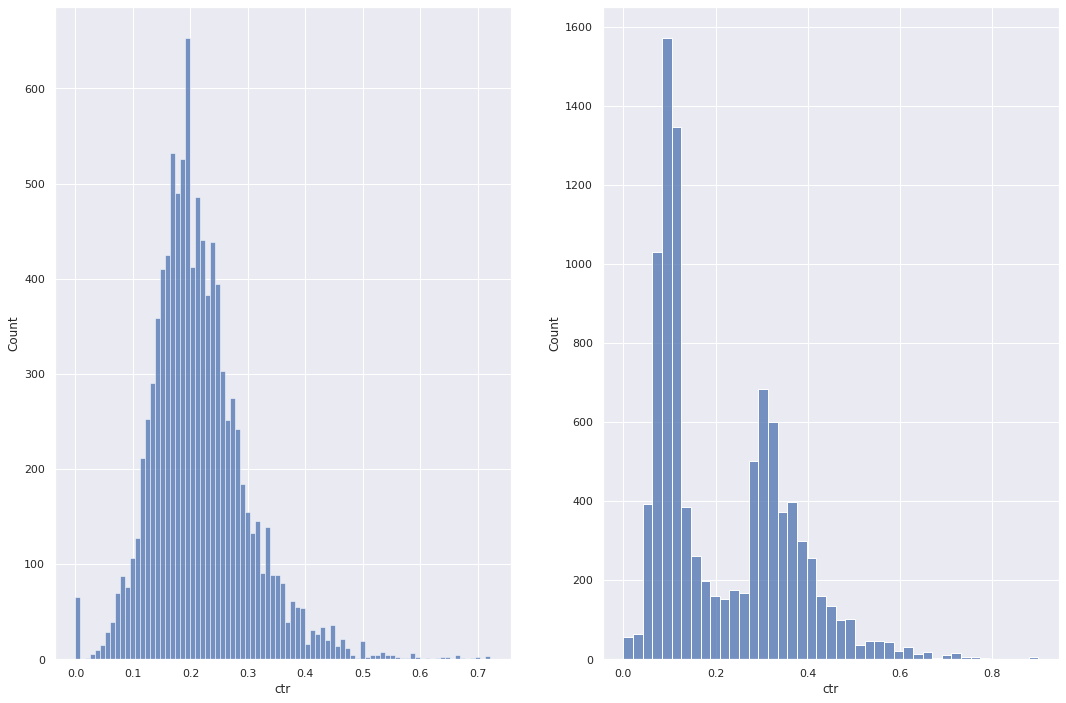

In [12]:
# Вычисляем глобальный CTR и выводим гистограмы CTR в группах

def get_smothed_ctr(user_likes, user_views, global_ctr, alpha):
    smothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
    return smothed_ctr


global_ctr_1 = df[df.exp_group == 1].likes.sum()/df[df.exp_group == 1].views.sum()
global_ctr_2 = df[df.exp_group == 2].likes.sum()/df[df.exp_group == 2].views.sum()

plt.subplot(1, 2, 1)
group1 = df[df.exp_group == 1].copy()
sns.histplot(group1.ctr, 
             kde = False)
plt.subplot(1, 2, 2)
group2 = df[df.exp_group == 2].copy()
sns.histplot(group2.ctr, 
             kde = False)

<Axes: xlabel='smothed_ctr', ylabel='Count'>

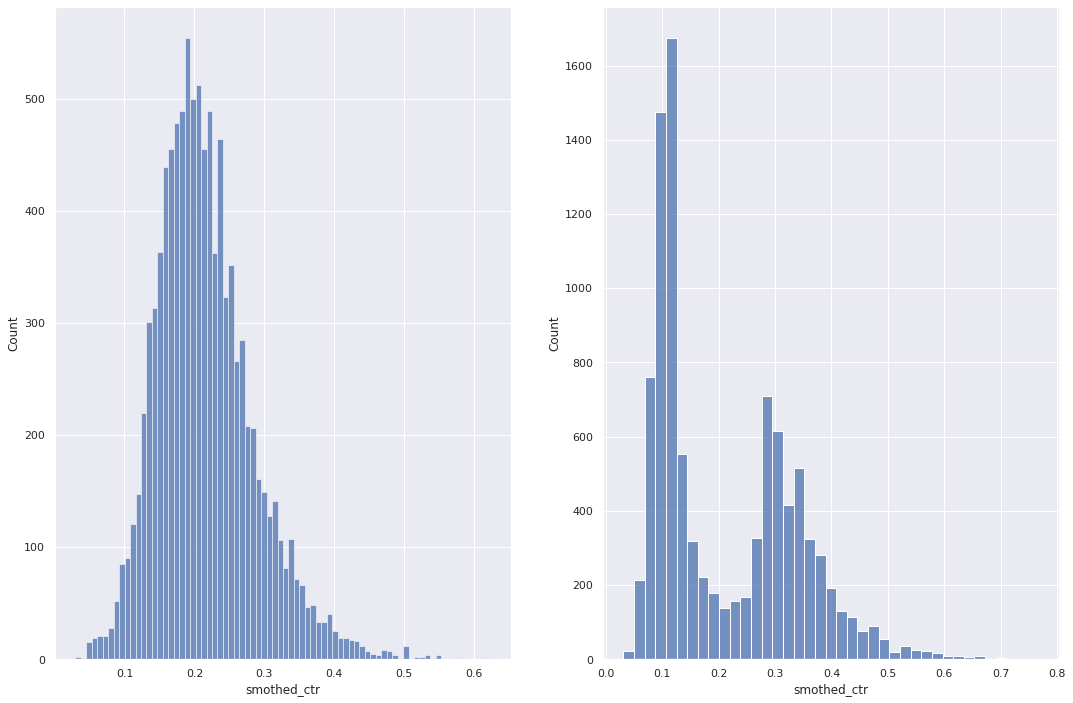

In [13]:
# Вычисляем сглаженный CTR и строим гистограммы для сглаженного CTR

group1['smothed_ctr'] = df.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_1, 5), axis=1)
group2['smothed_ctr'] = df.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_2, 5), axis=1)

plt.subplot(1, 2, 1)
sns.histplot(group1.smothed_ctr, 
             kde = False)
plt.subplot(1, 2, 2)
sns.histplot(group2.smothed_ctr, 
             kde = False)

In [14]:
# T-тест для сглаженного CTR

stats.ttest_ind(group1[group1.exp_group == 1].smothed_ctr,
                group2[group2.exp_group == 2].smothed_ctr,
                equal_var=False)

Ttest_indResult(statistic=1.9460491517027683, pvalue=0.05166679015318526)

Согласно t-тесту p value получается незначительно больше 0.05. То есть мы не принимаем гипотезу о том, что новая система рекомендаций приводит к увееличению CTR.

## Пуассоновский бутстреп

<Axes: ylabel='Count'>

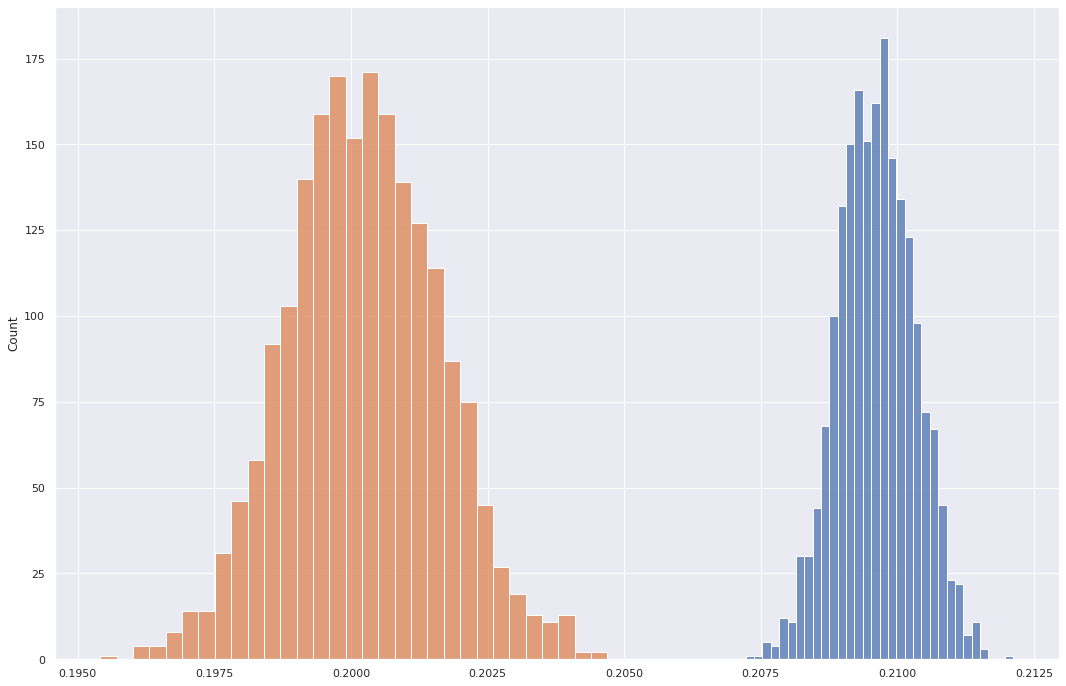

In [16]:
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):

    poisson_bootstraps1 = stats.poisson(1).rvs(
        (n_bootstrap, len(likes1))).astype(np.int64)

    poisson_bootstraps2 = stats.poisson(1).rvs(
            (n_bootstrap, len(likes2))).astype(np.int64)
    
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)

    return globalCTR1, globalCTR2



likes1 = df[df.exp_group == 1].likes.to_numpy()
views1 = df[df.exp_group == 1].views.to_numpy()
likes2 = df[df.exp_group == 2].likes.to_numpy()
views2 = df[df.exp_group == 2].views.to_numpy()

ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)

sns.histplot(ctr1)
sns.histplot(ctr2)

<Axes: ylabel='Count'>

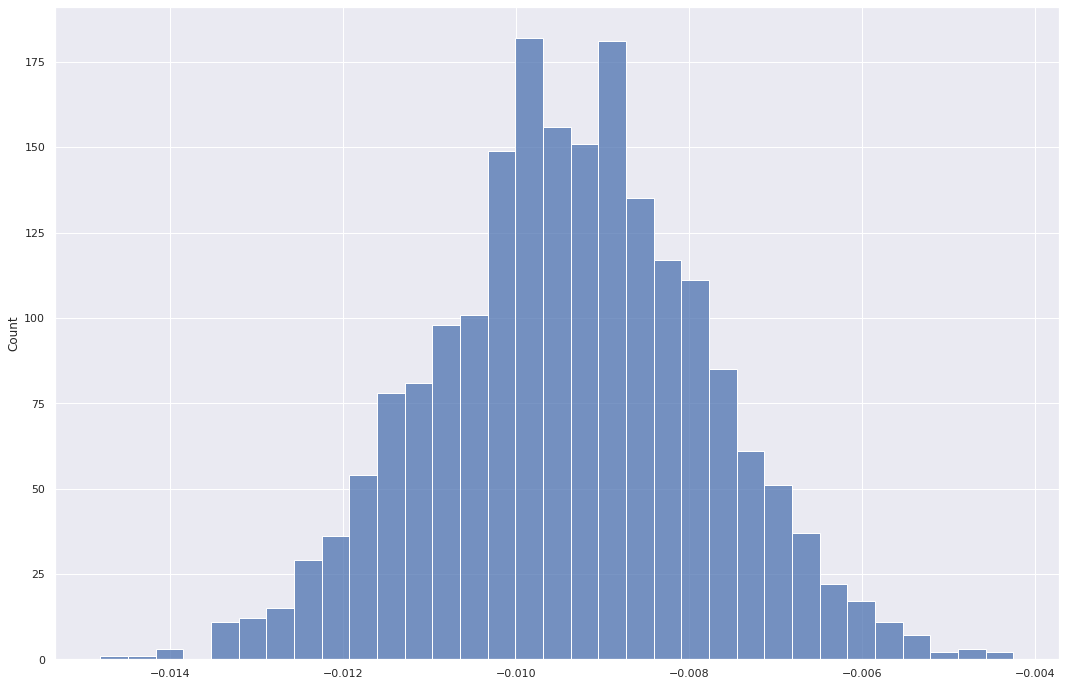

In [17]:
sns.histplot(ctr2 - ctr1)

После бутстрепа распределения CTR получились непересекающимися. Причем CTR в первой группе был больше чем во второй (это видно из распределения разности CTR). Таким образом мы не принимаем гипотезу о том, что новая система рекомендаций приводит к увееличению CTR. Потому что новая система рекомендаций привела к снижению CTR.

##  T-тест и тест Манна-Уитни поверх бакетного преобразования

In [19]:
#Разобьем пользователей на 50 бакетов

q = """

SELECT exp_group, bucket,
    sum(likes)/sum(views) as bucket_ctr,
    quantileExact(0.9)(ctr) as ctr9
FROM (SELECT exp_group, 
        xxHash64(user_id)%50 as bucket,
        user_id,
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr
    FROM {db}.feed_actions 
    WHERE toDate(time) between '2023-06-30' and '2023-07-06'
        and exp_group in (1,2)
    GROUP BY exp_group, bucket, user_id)
GROUP BY exp_group, bucket
"""

df = pandahouse.read_clickhouse(q, connection=connection)

In [20]:
# Проведем тест Манна-Уитни
stats.mannwhitneyu(df[df.exp_group == 1].bucket_ctr, 
                   df[df.exp_group == 2].bucket_ctr, 
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=1997.0, pvalue=2.6576427804010095e-07)

В результате теста получаем маленькое значение p value. То есть гипотеза о том, что новая система рекомендаций приводит к увееличению CTR принимается.

In [21]:
# Проведем t-тест
stats.ttest_ind(df[df.exp_group == 1].bucket_ctr, 
                   df[df.exp_group == 2].bucket_ctr, 
                   equal_var = False)

Ttest_indResult(statistic=5.614819358149381, pvalue=4.592644937473873e-07)

Аналогисчно, в результате теста получаем маленькое значение p value. То есть гипотеза о том, что новая система рекомендаций приводит к увееличению CTR принимается

## Выводы
Мы провели 5 различных статистических тестов для принятия решения о вводе новой системы рекомендаций.\
Разные тесты показали разные результаты. Это могло произойти по разным причинам. Например, новая система рекомендаций по разному действует на пользователей внутри групп. То есть на кого-то она оказывает положительное влияние и эти пользователи начинают ставить больше лайков, их CTR увеличивается, а на кого-то она оказывает наоборот отрицательное влияние. \
Таким образом, на данный момент я бы не рекомендовал вводить новую систему рекомендаций. Необходимо провести дополнительные исследования.